### Similaridade de vozes - Disfarces

Em resultado.csv temos a comparação entre os embeddings gerados pelo deep speaker para cada trecho de áudio disponível no dataset. A comparação é por similaridade de cosseno.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

df = pd.read_csv('resultado.csv')

df.head()

,voz-1,classe-1,voz-2,classe-2,score
0,GH7,DISFARCE,GH7,DISFARCE,1.000000
1,GH7,DISFARCE,GH7,DISFARCE,0.614986
2,GH7,DISFARCE,GH7,DISFARCE,0.747182
3,GH7,DISFARCE,GH7,DISFARCE,0.735326
4,GH7,DISFARCE,GH7,DISFARCE,0.610291


#### Removendo os scores da comparação entre um arquivo de áudio com ele mesmo, o score dá 1

In [2]:
print(df.shape)
df = df.drop(df[df['score']>0.99].index)
print(df.shape)
df.head()

(203841, 5)
(203193, 5)


,voz-1,classe-1,voz-2,classe-2,score
1,GH7,DISFARCE,GH7,DISFARCE,0.614986
2,GH7,DISFARCE,GH7,DISFARCE,0.747182
3,GH7,DISFARCE,GH7,DISFARCE,0.735326
4,GH7,DISFARCE,GH7,DISFARCE,0.610291
5,GH7,DISFARCE,GH7,DISFARCE,0.616554


#### Cada combinação voz-classe tem de 2 a 8 trechos de áudio de aproximadamente 8 segundos
#### Uso a média dos scores desses trechos como métrica para os experimentos

In [3]:
#médias entre uma voz e classe com as demais
df_medias = df.groupby(['voz-1', 'classe-1', 'voz-2', 'classe-2']).mean()

# comparação de uma voz com ela mesma
print(df_medias.loc['GH1', :, 'GH1',:])

#comparação de uma voz de um homem com uma de outro homem 
print(df_medias.loc['GH1', :, 'GH2', :])
print(df_medias.loc['GH2', :, 'GH1', :])

#mais uma, agora homem e rapaz
print(df_medias.loc['GH1', :, 'GR1', :])
print(df_medias.loc['GR1', :, 'GH1', :])

                                  score
voz-1 classe-1 voz-2 classe-2          
GH1   DISFARCE GH1   DISFARCE  0.746833
                     NORMAL    0.624282
      NORMAL   GH1   NORMAL    0.687960
                                  score
voz-1 classe-1 voz-2 classe-2          
GH1   DISFARCE GH2   NORMAL    0.546969
      NORMAL   GH2   NORMAL    0.560694
                                  score
voz-1 classe-1 voz-2 classe-2          
GH2   DISFARCE GH1   DISFARCE  0.564198
                     NORMAL    0.524883
                                  score
voz-1 classe-1 voz-2 classe-2          
GH1   DISFARCE GR1   DISFARCE  0.480518
                     NORMAL    0.506974
      NORMAL   GR1   NORMAL    0.552463
                                  score
voz-1 classe-1 voz-2 classe-2          
GR1   DISFARCE GH1   NORMAL    0.493377


### Abaixo seguem várias comparações para os scores entre vozes e vozes-classes.
#### A principal informação aqui é de que a média dos scores para vozes iguais bem maior que para vozes diferentes, como esperado

In [4]:
#sumário para mesma voz
df[df['voz-1'] == df['voz-2']]['score'].describe()

count    4169.000000
mean        0.667319
std         0.113398
min         0.177960
25%         0.603195
50%         0.687062
75%         0.748153
max         0.953725
Name: score, dtype: float64

In [5]:
#sumário para vozes diferentes
df[df['voz-1'] != df['voz-2']]['score'].describe()

count    199024.000000
mean          0.366731
std           0.144214
min          -0.241430
25%           0.265812
50%           0.366823
75%           0.470230
max           0.854398
Name: score, dtype: float64

In [6]:
#sumário para mesma voz, mesma classe(normal ou disfarçado)
df[(df['voz-1'] == df['voz-2']) & (df['classe-1'] == df['classe-2'])]['score'].describe()

count    2033.000000
mean        0.700238
std         0.103581
min         0.206756
25%         0.654287
50%         0.721117
75%         0.769749
max         0.908317
Name: score, dtype: float64

In [7]:
#sumário para mesma voz, classes diferentes (normal ou disfarçado)
df[(df['voz-1'] == df['voz-2']) & (df['classe-1'] != df['classe-2'])]['score'].describe()

count    2136.000000
mean        0.635988
std         0.113483
min         0.177960
25%         0.567853
50%         0.652163
75%         0.718801
max         0.953725
Name: score, dtype: float64

In [8]:
#sumário para vozez diferentes, mesma classe(normal ou disfarçado)
df[(df['voz-1'] != df['voz-2']) & (df['classe-1'] == df['classe-2'])]['score'].describe()

count    99572.000000
mean         0.368777
std          0.144728
min         -0.217313
25%          0.267510
50%          0.369501
75%          0.472547
max          0.828025
Name: score, dtype: float64

In [9]:
#sumário para vozes diferentes, classes diferentes (normal ou disfarçado)
df[(df['voz-1'] != df['voz-2']) & (df['classe-1'] != df['classe-2'])]['score'].describe()

count    99452.000000
mean         0.364682
std          0.143670
min         -0.241430
25%          0.264362
50%          0.364314
75%          0.467882
max          0.854398
Name: score, dtype: float64

#### Aqui seleciono para comparação os scores entre vozes iguais e vozes diferentes do mesmo grupo(Homem, mulher, garoto, garota e criança). Isso deixa o dataset mais balanceado porém preservando as comparações mais difíceis, com vozes parecidas.

In [10]:
df_different_voice_same_group = df[(df['voz-1'] != df['voz-2']) & ((df['voz-1'].str[:2] == df['voz-2'].str[:2]))]
df_same_voice = df[(df['voz-1'] == df['voz-2'])]

df_novo = pd.concat([df_same_voice, df_different_voice_same_group])
df_novo = df_novo.groupby(['voz-1','classe-1', 'voz-2', 'classe-2'], as_index=False).mean()

### Métricas para as comparações. Como o dataset continua desbalanceado, com mais combinações de vozes diferentes do que iguais, o F1 score é mais útil.

In [11]:
#métricas para um corte de 0.62
df_novo['predito'] = np.where(df_novo['score'] > 0.62,1,0)
df_novo['y'] = np.where(df_novo['voz-1'] == df_novo['voz-2'], 1, 0)
print('f1 score: ', f1_score(df_novo['y'], df_novo['predito']))
print('precision: ', precision_score(df_novo['y'], df_novo['predito']))
print('recall: ', recall_score(df_novo['y'], df_novo['predito']))
print('acurácia: ', accuracy_score(df_novo['y'], df_novo['predito']))

f1 score:  0.8623188405797101
precision:  0.85
recall:  0.875
acurácia:  0.9594017094017094


### Matriz de confusão

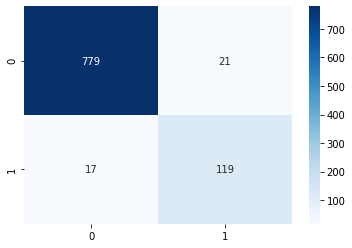

In [12]:
cf_matrix = confusion_matrix(df_novo['y'], df_novo['predito'])

sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

### Curva ROC

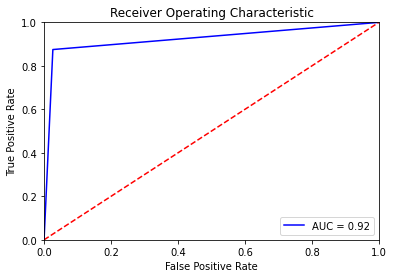

In [13]:

from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(df_novo['y'], df_novo['predito'])
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Análise dos exemplos em que houve predição errada

In [14]:
df_erros = df_novo[df_novo['y'] != df_novo['predito']]

### Erros de vozes diferentes classificadas como mesma voz. 

In [15]:
df_erros[(df_erros['classe-1'] != df_erros['classe-2']) & (df_erros['y'] == 0)]

,voz-1,classe-1,voz-2,classe-2,score,predito,y
103,GG1,DISFARCE,GG6,NORMAL,0.637487,1,0
182,GG4,DISFARCE,GG6,NORMAL,0.629277,1,0
196,GG5,DISFARCE,GG10,NORMAL,0.637012,1,0
205,GG5,DISFARCE,GG6,NORMAL,0.671942,1,0
218,GG6,DISFARCE,GG1,NORMAL,0.641059,1,0
226,GG6,DISFARCE,GG5,NORMAL,0.664553,1,0
683,GM7,DISFARCE,GM8,NORMAL,0.621578,1,0
832,GR5,DISFARCE,GR4,NORMAL,0.629084,1,0


In [19]:
df_erros[(df_erros['classe-1'] == df_erros['classe-2']) & (df_erros['y'] == 0)]

,voz-1,classe-1,voz-2,classe-2,score,predito,y
102,GG1,DISFARCE,GG6,DISFARCE,0.638948,1,0
126,GG10,NORMAL,GG6,NORMAL,0.661986,1,0
191,GG4,NORMAL,GG6,NORMAL,0.635717,1,0
195,GG5,DISFARCE,GG10,DISFARCE,0.623119,1,0
200,GG5,DISFARCE,GG4,DISFARCE,0.634625,1,0
204,GG5,DISFARCE,GG6,DISFARCE,0.644522,1,0
211,GG5,NORMAL,GG10,NORMAL,0.624622,1,0
215,GG5,NORMAL,GG6,NORMAL,0.711238,1,0
233,GG6,NORMAL,GG1,NORMAL,0.667811,1,0
248,GG7,NORMAL,GG6,NORMAL,0.631837,1,0


### Erros para mesma voz classificada como vozes diferentes. Aqui vemos que o disfarce na voz teve algum efeito para enganar o modelo, com 11 exemplos de classes diferentes classificadas incorretamente contra 6 para a mesma classe. Destaque para os dois exemplos em que o score ficou abaixo de 0.5, mostrando que o disfarce aqui foi efetivo. 

In [20]:
df_erros[(df_erros['classe-1'] != df_erros['classe-2']) & (df_erros['y'] == 1)]

,voz-1,classe-1,voz-2,classe-2,score,predito,y
132,GG2,DISFARCE,GG2,NORMAL,0.532746,0,1
267,GG8,DISFARCE,GG8,NORMAL,0.577877,0,1
323,GH10,DISFARCE,GH10,NORMAL,0.419517,0,1
365,GH3,DISFARCE,GH3,NORMAL,0.600186,0,1
457,GH7,DISFARCE,GH7,NORMAL,0.580514,0,1
561,GM2,DISFARCE,GM2,NORMAL,0.582114,0,1
589,GM3,DISFARCE,GM3,NORMAL,0.435819,0,1
639,GM5,DISFARCE,GM5,NORMAL,0.556246,0,1
700,GM8,DISFARCE,GM8,NORMAL,0.590487,0,1
722,GR1,DISFARCE,GR1,NORMAL,0.614830,0,1


In [18]:
df_erros[(df_erros['classe-1'] == df_erros['classe-2']) & (df_erros['y'] == 1)]

,voz-1,classe-1,voz-2,classe-2,score,predito,y
131,GG2,DISFARCE,GG2,DISFARCE,0.614978,0,1
266,GG8,DISFARCE,GG8,DISFARCE,0.611017,0,1
364,GH3,DISFARCE,GH3,DISFARCE,0.608386,0,1
419,GH5,NORMAL,GH5,NORMAL,0.590123,0,1
528,GM1,NORMAL,GM1,NORMAL,0.607183,0,1
924,GR9,DISFARCE,GR9,DISFARCE,0.588503,0,1


### Diferença de acurácia para mesma voz classificada como voz diferente dependendo da classe. Quando há disfarce a acurácia é de 74% enquando quando não há disfarce a acurácia é de 97.8%. Considerando apenas os dois exemplos em que o score foi menor que 0.5, a acurácia quando há disfarce

In [30]:
erros = df_erros[(df_erros['classe-1'] != df_erros['classe-2']) & (df_erros['y'] == 1)].shape[0]
total = df_novo[(df_novo['y'] == 1) & (df_novo['classe-1'] != df_novo['classe-2'])].shape[0]
print(1 - 2/total)
1 - erros/total

0.9534883720930233


0.7441860465116279

In [29]:
erros = df_erros[(df_erros['classe-1'] == df_erros['classe-2']) & (df_erros['y'] == 1) & (df_erros['classe-1'] == 'NORMAL')].shape[0]
total = df_novo[(df_novo['y'] == 1) & (df_novo['classe-1'] == df_novo['classe-2'])].shape[0]

1 - erros/total

0.978494623655914